In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.mapping_utils as mu

#### We first download the data
- We will use [snRNA-seq data](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/visp_sn_tpm_small_0430.h5ad) (adult mouse brain; VISp area).
- And [slide-seqv2 data](
https://storage.googleapis.com/tommaso-brain-data/tangram_demo/slideseq_MOp_cropped_DUAL.h5ad.gz) (adult mouse brain; MOp area).
- The two datasets should be placed in the `data` folder.

#### Slide-seq data
- Slide-seq data contains 9852 spatial voxels, in each of which they measured 24518 genes.

In [2]:
path = os.path.join('data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

- We visualize the spatial ROI. Each "dot" is the center of a 10um voxel.

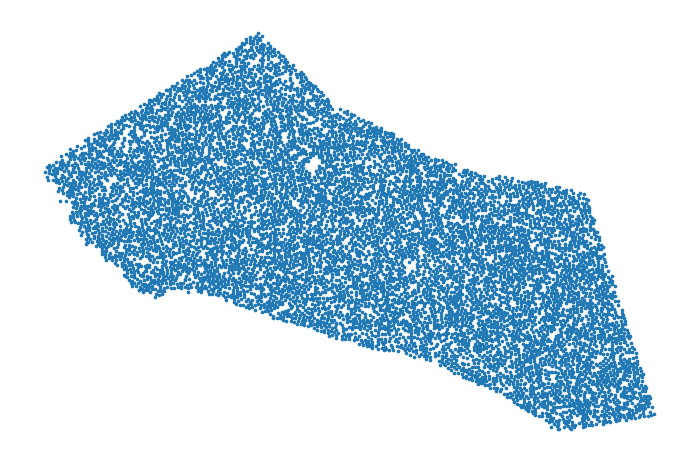

In [3]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);

raw count? Visualize marker?

In [4]:
path = os.path.join('data', 'slideseq_MOp_cropped_1217.h5ad')
ad_sp.write_h5ad(path)

***
### Single cell data

- By single cell data, we mean either scRNAseq or snRNAseq.
- The following dataset contains single nuclei collected from a posterior region of the primary motor cortex.
- They are approximately 53k cells.

In [5]:
path = os.path.join('data','mop_P_allen.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 52923 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [6]:
df_obs  = ad_sc.obs.sample(frac=.7)
ad_sc = ad_sc[df_obs.index, :].copy()

- Usually, we work with data in raw count form (but not necessarily), especially if the spatial data are in raw count form as well.
- If the data are in integer format, that probably means they are in raw count.

In [7]:
np.unique(ad_sc.X.toarray()[0, :])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  26.,  27.,  28.,  30.,  31.,  35.,  36.,  39.,
        41.,  42.,  49.,  50.,  71.,  75., 272.], dtype=float32)

- We only do some light pre-processing such as library size correction (in scanpy, `sc.pp.normalize`).
- That normalize the number of count within each cell to a fixed number.
- Note that the resulting values might not be integer, still they quality as "count form".
- More sophisticated pre-processing is also possible, such as batch correction.
- Ideally, the single cell and spatial datasets, should exhibit signals as similar as possible.

In [8]:
sc.pp.normalize_total(ad_sc)

- It is a good idea to have annotations in the single cell data, as they will be projected on space after we map.
- In this case, we use the `subclass_label` annotations which contain the cell type.
- Here we show a count

In [9]:
ad_sc.obs.subclass_label.value_counts()

L5 IT        7927
Oligo        6030
L2/3 IT      5069
L6 CT        4338
Astro        3612
Micro-PVM    1567
Pvalb        1348
L5 ET        1272
L6 IT        1260
L5/6 NP       913
Sst           889
Vip           583
Endo          485
L6b           481
Lamp5         460
VLMC          356
Peri          279
Sncg          128
Sst Chodl      38
Meis2          10
SMC             1
Name: subclass_label, dtype: int64

- For this mapping, we exclude cell types which are rare in the snRNAseq.
- Actually, Tangram can "reuse" the same cell multiple times because mapping is probabilistic.
- But for this case, we want Tangram to have "enough puzzle pieces" for each cell type.

In [10]:
rare_cts = ['Meis2', 'SMC', 'Sst Chodl']
mask = ~ad_sc.obs.subclass_label.isin(rare_cts)
ad_sc = ad_sc[mask, :]
ad_sc.obs.subclass_label.value_counts()

L5 IT        7927
Oligo        6030
L2/3 IT      5069
L6 CT        4338
Astro        3612
Micro-PVM    1567
Pvalb        1348
L5 ET        1272
L6 IT        1260
L5/6 NP       913
Sst           889
Vip           583
Endo          485
L6b           481
Lamp5         460
VLMC          356
Peri          279
Sncg          128
Name: subclass_label, dtype: int64

***
## Prepare to map

- Tangram learns a spatial alignment of the single cell data so that  _the gene expression of the aligned single cell data is as similar as possible to that of the spatial data_.
- Tangram restricts the search only to a set of genes, specified by the user, called the training genes.
- The choice of the training genes is a delicate step for mapping: they need to bear interesting signals and to be measured with high quality.
- Typically, a good start is to choose 100-1000 top marker genes, evenly stratified across cell types.
- For this case, we choose 253 marker genes of the MOp area which were curated [in a different study](https://www.biorxiv.org/content/10.1101/2020.06.04.105700v1).

In [11]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)
len(markers)

253

- We now need to prepare the datasets for mapping.
- The two `AnnData` structures need to be subset on the list of training genes.
- Second, the gene order needs to be the same in the datasets. This is because Tangram maps using only gene expression, so the $j$-th column in each matrix must correspond to the same gene.
- This task is performed by the helper `prepare_adatas_cell_space`.

In [12]:
ad_sc, ad_sp = mu.prepare_adatas_cell_space(
    adata_cells=ad_sc, 
    adata_space=ad_sp, 
    marker_genes=markers
)

- You'll now notice that the two datasets now contain 252 genes, but 253 markers were provided.
- This is because the marker genes need to be shared by both dataset. If a gene is missing, `prepare_adatas` will just take it out.
- Finally, the `assert` line below is a good way to ensure that the genes in the `AnnData`s are actually ordered.

In [13]:
ad_sc

View of AnnData object with n_obs × n_vars = 36997 × 252
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [14]:
assert ad_sc.var.index.equals(ad_sp.var.index)

- At this point, it is a good to save the structures, then restart the python kernel.
- This is because we want to free as much memory as possible so that we can map.

In [15]:
ad_sc.write_h5ad('ad_sc_readytomap.h5ad')

In [16]:
ad_sp.write_h5ad('ad_sp_readytomap.h5ad')

***
## Map

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add `Tangram` to path
sys.path.append("../") 

# Tangram imports
import mapping.mapping_utils as mu

In [2]:
ad_sp = sc.read_h5ad('ad_sp_readytomap.h5ad')
ad_sc = sc.read_h5ad('ad_sc_readytomap.h5ad')

- We can now train the model (_ie_ map).
- The score indicates

In [3]:
ad_map = mu.map_cells_2_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
)

Main loss: 0.102, KL reg: nan, VG reg: nan
Main loss: 0.789, KL reg: nan, VG reg: nan
Main loss: 0.808, KL reg: nan, VG reg: nan
Main loss: 0.812, KL reg: nan, VG reg: nan
Main loss: 0.814, KL reg: nan, VG reg: nan
Main loss: 0.815, KL reg: nan, VG reg: nan
Main loss: 0.816, KL reg: nan, VG reg: nan
Main loss: 0.816, KL reg: nan, VG reg: nan
Main loss: 0.817, KL reg: nan, VG reg: nan
Main loss: 0.817, KL reg: nan, VG reg: nan
